In [3]:
import duckdb 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
path = "/home/etienne/projects/obsq/work/dev/data/data.duckdb"
target = 'expert_match'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
table = 'combined'
schema = 'features'
con = duckdb.connect(path)
df = con.execute(f"""SELECT* FROM {schema}.{table}""" ).df()
#df = df.drop(columns= 'geom')
con.close()

In [5]:
cols_to_remove = ['tempo_eventDate']
cols_to_remove.append(target)
cols_to_remove.append('gbifID')
cols_to_remove.append('species')

In [6]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision'  # Better for imbalanced data
}

In [7]:
#One hot encode 
codes, uniques = pd.factorize(df['species'])
df['species_encoded'] = codes
uniques

Index(['Actaea pachypoda', 'Populus deltoides', 'Rubus idaeus',
       'Persicaria maculosa', 'Alliaria petiolata', 'Frangula alnus',
       'Cypripedium acaule', 'Elaeagnus angustifolia', 'Verbascum thapsus',
       'Claytonia caroliniana',
       ...
       'Carex atlantica', 'Centaurium erythraea', 'Potamogeton illinoensis',
       'Viola renifolia', 'Dichanthelium xanthophysum', 'Alnus alnobetula',
       'Acalypha rhomboidea', 'Campanula intercedens', 'Cryptogramma stelleri',
       'Podophyllum peltatum'],
      dtype='object', length=1250)

In [8]:
X = df.drop(columns=cols_to_remove)
y = df[target]


In [9]:
X.head()

,obsv_obs_count,obsv_total_pct,obsv_expert_ids,obsv_expert_ids_pct,obsv_avg_id_time,obsv_class_count,obsv_order_count,obsv_family_count,obsv_genus_count,obsv_species_count,...,meta_pheno_leaves,meta_pheno_sex,meta_occurrenceRemarks,pheno_leaves_month_density,pheno_sex_month_density,pheno_repro_month_density,taxo_freq,taxo_confusability_index,spatial_cluster,species_encoded
0,3389,0.08525,38,0.01100,17.00000,5,39,97,244,352,...,1,0,0,0.20000,NaN,0.14400,0.05700,0,1,0
1,3389,0.08525,38,0.01100,17.00000,5,39,97,244,352,...,1,0,0,0.22900,NaN,0.05500,2.74300,24,1,1
2,330,0.00830,0,0.00000,6.00000,5,34,69,137,170,...,1,0,0,0.18900,NaN,0.76700,1.61900,24,5,2
3,21,0.00053,0,0.00000,25.00000,3,16,19,19,19,...,1,0,0,0.05300,NaN,0.12500,0.01000,0,1,3
4,3389,0.08525,38,0.01100,17.00000,5,39,97,244,352,...,1,0,0,0.09100,NaN,0.23800,0.12600,0,1,4


In [10]:
X.shape[0]

39895

In [14]:
#Define model params
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    n_jobs=-1
)

In [12]:
#Define model params
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

In [15]:
#Fit model
model.fit(X, y)



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [16]:
#Feature importance
importances = model.feature_importances_
    
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

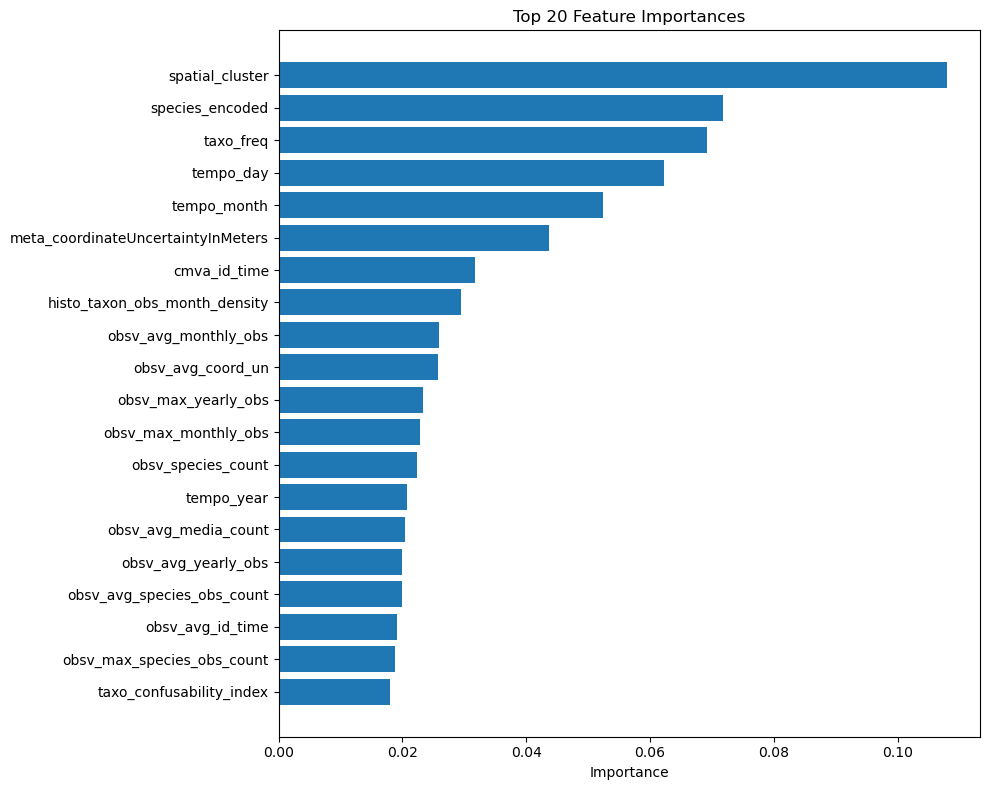


Top 10 Most Important Features:
spatial_cluster               : 0.1079
species_encoded               : 0.0718
taxo_freq                     : 0.0692
tempo_day                     : 0.0623
tempo_month                   : 0.0524
meta_coordinateUncertaintyInMeters: 0.0436
cmva_id_time                  : 0.0317
histo_taxon_obs_month_density : 0.0295
obsv_avg_monthly_obs          : 0.0260
obsv_avg_coord_un             : 0.0258


In [17]:
# 7. ANALYZE FEATURE IMPORTANCE

def plot_feature_importance(importance_df, top_n=20):
    """
    Visualize which features matter most.
    
    This tells you what the model learned.
    """
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print("="*60)
    for idx, row in top_features.head(10).iterrows():
        print(f"{row['feature']:30s}: {row['importance']:.4f}")


plot_feature_importance(feature_importance_df)